Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=376, subsample=0.6; total time=  25.3s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=376, subsample=0.6; total time=  25.4s
[CV] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=206, subsample=0.6; total time=  25.5s
[CV] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=206, subsample=0.6; total time=  25.6s
[CV] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=206, subsample=0.6; total time=  25.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=9, n_estimators=591, subsample=0.8; total time=  32.8s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=9, n_estimators=591, subsample=0.8; total time= 

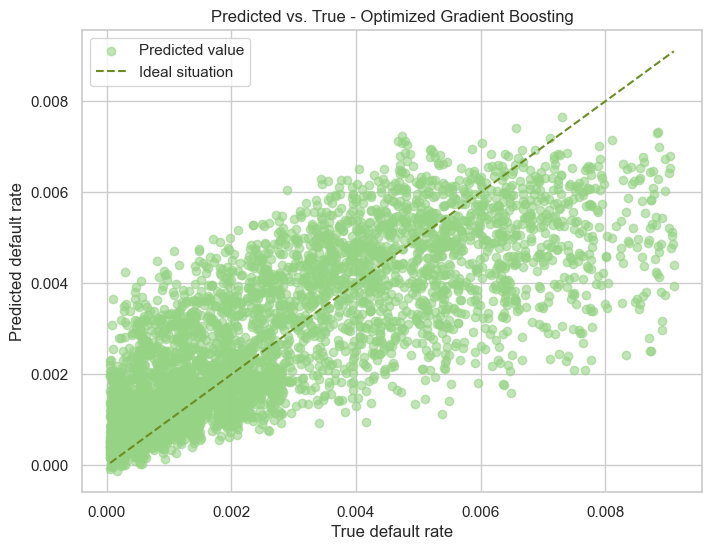

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, randint

# 1️⃣ 读取数据
file_path = "GreenLoan_cleaned.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ 处理异常值
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 3️⃣ 处理类别变量（仅转换 'Industry'）
# 1️⃣ 需要转换的类别列
categorical_cols = ["Industry", "province"]

# 2️⃣ 创建一个字典存储 LabelEncoders
label_encoders = {}

# 3️⃣ 遍历每一列进行编码
for col in categorical_cols:
    le = LabelEncoder()  # 创建 LabelEncoder
    df[col] = le.fit_transform(df[col])  # 进行编码
    label_encoders[col] = le  # 保存编码器，以便以后解码

# 4️⃣ 选择特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])  # 特征
y = df["Green credit default rate"]  # 目标变量

# 5️⃣ 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7️⃣ 定义 Gradient Boosting 超参数搜索范围
param_dist = {
    'n_estimators': randint(100, 1000),  # 决策树的数量
    'max_depth': [3, 5, 7, 10],  # 树的最大深度
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 学习率
    'subsample': [0.6, 0.8, 1.0],  # 采样比例
    'min_samples_split': randint(2, 10),  # 内部节点拆分的最小样本数
    'min_samples_leaf': randint(1, 5),  # 叶节点的最小样本数
}

# 8️⃣ 使用 RandomizedSearchCV 进行超参数优化
gbr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    gbr, param_distributions=param_dist,
    n_iter=50, cv=3, scoring="r2",
    n_jobs=-1, verbose=2, random_state=42
)

random_search.fit(X_train, y_train)

# 9️⃣ 获取最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 🔟 使用最佳参数训练最终 Gradient Boosting 模型
best_gbr_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr_model.fit(X_train, y_train)

# 1️⃣1️⃣ 预测
y_pred = best_gbr_model.predict(X_test)

# 1️⃣2️⃣ 计算回归指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

# 1️⃣3️⃣ 打印结果
print(f"R² Score: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Spearman Correlation: {spearman_corr:.6f}")

# 1️⃣4️⃣ 可视化预测值 vs 真实值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="#96D385", label="Predicted value")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="olivedrab", linestyle="--", label="Ideal situation")
plt.xlabel("True default rate")
plt.ylabel("Predicted default rate")
plt.title("Predicted vs. True - Optimized Gradient Boosting")
plt.legend()
plt.show()

Repeated Train/Val Split: 100%|██████████| 500/500 [2:23:22<00:00, 17.21s/it]    


Validation Set Performance:
R²        : 0.606867
RMSE      : 0.001425
MAE       : 0.001059
Spearman  : 0.802940
Test Set Performance:
R²        : 0.606420
RMSE      : 0.001427
MAE       : 0.001067
Spearman  : 0.798409


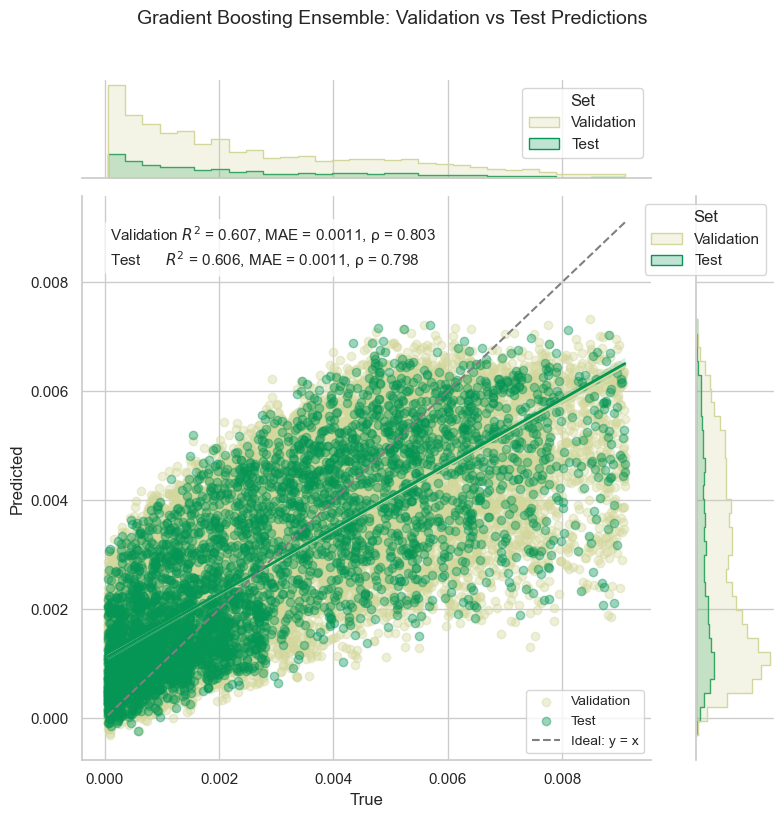

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr
from tqdm import tqdm

# 1️⃣ 读取数据
df = pd.read_excel("GreenLoan_cleaned.xlsx")

# 2️⃣ 清洗数据
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 3️⃣ 编码类别变量
categorical_cols = ["Industry", "province"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4️⃣ 特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])
y = df["Green credit default rate"]

# 5️⃣ 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 拆分训练集与测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 7️⃣ 多轮训练并保存结果
n_repeats = 500
results = []
y_test_preds = []
y_val_preds = []  # ✅ 保存验证集预测（含索引）

for i in tqdm(range(n_repeats), desc="Repeated Train/Val Split"):
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=i)

    model = GradientBoostingRegressor(random_state=i)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_preds.append((y_val.index, y_val_pred))  # ✅ 保存验证集预测

    y_test_pred = model.predict(X_test)
    y_test_preds.append(y_test_pred)

    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)
        return r2, mse, rmse, mae, spearman_corr

    r2_val, mse_val, rmse_val, mae_val, spearman_val = evaluate(y_val, y_val_pred)
    r2_test, mse_test, rmse_test, mae_test, spearman_test = evaluate(y_test, y_test_pred)

    results.append({
        "run": i + 1,
        "R2_val": r2_val,
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "Spearman_val": spearman_val,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "Spearman_test": spearman_test
    })

# 8️⃣ 测试集集成预测
y_test_ensemble_pred = np.mean(y_test_preds, axis=0)

# 9️⃣ 验证集平均预测（按索引）
val_pred_dict = {}
for idx, preds in y_val_preds:
    for i, row_id in enumerate(idx):
        if row_id not in val_pred_dict:
            val_pred_dict[row_id] = []
        val_pred_dict[row_id].append(preds[i])

val_avg_preds = {k: np.mean(v) for k, v in val_pred_dict.items()}

# 🔟 构建验证集 DataFrame
df_val = pd.DataFrame({
    "True": y_trainval.loc[val_avg_preds.keys()],
    "Predicted": list(val_avg_preds.values()),
    "Set": "Validation"
})

# 🔟 构建测试集 DataFrame
df_test = pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_ensemble_pred,
    "Set": "Test"
})

# 🔁 合并数据
df_plot = pd.concat([df_val, df_test], ignore_index=True)

# ✅ 计算指标函数
def evaluate_set(name, df):
    r2 = r2_score(df["True"], df["Predicted"])
    rmse = np.sqrt(mean_squared_error(df["True"], df["Predicted"]))
    mae = mean_absolute_error(df["True"], df["Predicted"])
    spearman_corr, _ = spearmanr(df["True"], df["Predicted"])
    print(f"{name} Set Performance:")
    print(f"R²        : {r2:.6f}")
    print(f"RMSE      : {rmse:.6f}")
    print(f"MAE       : {mae:.6f}")
    print(f"Spearman  : {spearman_corr:.6f}")
    return r2, rmse, mae, spearman_corr

# ✅ 输出指标结果
r2_val, rmse_val, mae_val, spearman_val = evaluate_set("Validation", df_val)
r2_test, rmse_test, mae_test, spearman_test = evaluate_set("Test", df_test)

# 📈 可视化
sns.set(style="whitegrid")
palette = {"Validation": "#D3D79B", "Test": "#059554"}

g = sns.JointGrid(data=df_plot, x="True", y="Predicted", height=8)

for label, color in palette.items():
    subset = df_plot[df_plot["Set"] == label]
    g.ax_joint.scatter(subset["True"], subset["Predicted"], alpha=0.4, color=color, label=label)
    sns.regplot(data=subset, x="True", y="Predicted", scatter=False, ax=g.ax_joint,
                color=color, line_kws={"linewidth": 2})

# 理想线 y = x
min_val = df_plot["True"].min()
max_val = df_plot["True"].max()
g.ax_joint.plot([min_val, max_val], [min_val, max_val], '--', color='gray', label="Ideal: y = x")

# 边缘分布图
sns.histplot(data=df_plot, x="True", hue="Set", ax=g.ax_marg_x,
             bins=30, element="step", common_norm=False, palette=palette)
sns.histplot(data=df_plot, y="Predicted", hue="Set", ax=g.ax_marg_y,
             bins=30, element="step", common_norm=False, palette=palette)

# 注释指标
g.ax_joint.text(
    0.05, 0.95,
    f"Validation $R^2$ = {r2_val:.3f}, MAE = {mae_val:.4f}, ρ = {spearman_val:.3f}\n"
    f"Test      $R^2$ = {r2_test:.3f}, MAE = {mae_test:.4f}, ρ = {spearman_test:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 图例与标题
g.ax_joint.legend(loc="lower right", fontsize=10)
plt.suptitle("Gradient Boosting Ensemble: Validation vs Test Predictions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()